In [6]:
import pandas as pd

filename = "AMAZON_FASHION_5.json"

df = pd.read_json(path_or_buf=filename, lines=True)




In [2]:
import json

filename = "AMAZON_FASHION_5.json"
with open(filename) as f:
    reviews_json = f.readlines()

reviews = []
for review_json in reviews_json:
    review = json.loads(review_json)
    if "overall" in review and "reviewText" in review:
        reviews.append(
            {
                "rating": review["overall"],
                "title": review["summary"],
                "text": review["reviewText"],
            }
        )

#df = pd.DataFrame.from_dict(reviews)

In [10]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

# NMF and LDA
Adapted from [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html), minimal original work.

The topics are extracting nothing of note.

Further steps:

- find a product with enough reviews to be worth analyzing alone (might have to request the full dataset)
- mess around with heuristics for vectorizing terms (reducing `max_df` probably but didn't manage to get different results)
- eliminate boring reviews?

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

data = list(map(lambda x: x['text'], reviews))
data_samples = data[:n_samples]

In [30]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.7, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

Extracting tf-idf features for NMF...


In [32]:
# Fit the NMF model
print(
    "Fitting the NMF model (Frobenius norm) with tf-idf features, "
    "n_samples=%d and n_features=%d..." % (n_samples, n_features)
)
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=1,
).fit(tfidf)


Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


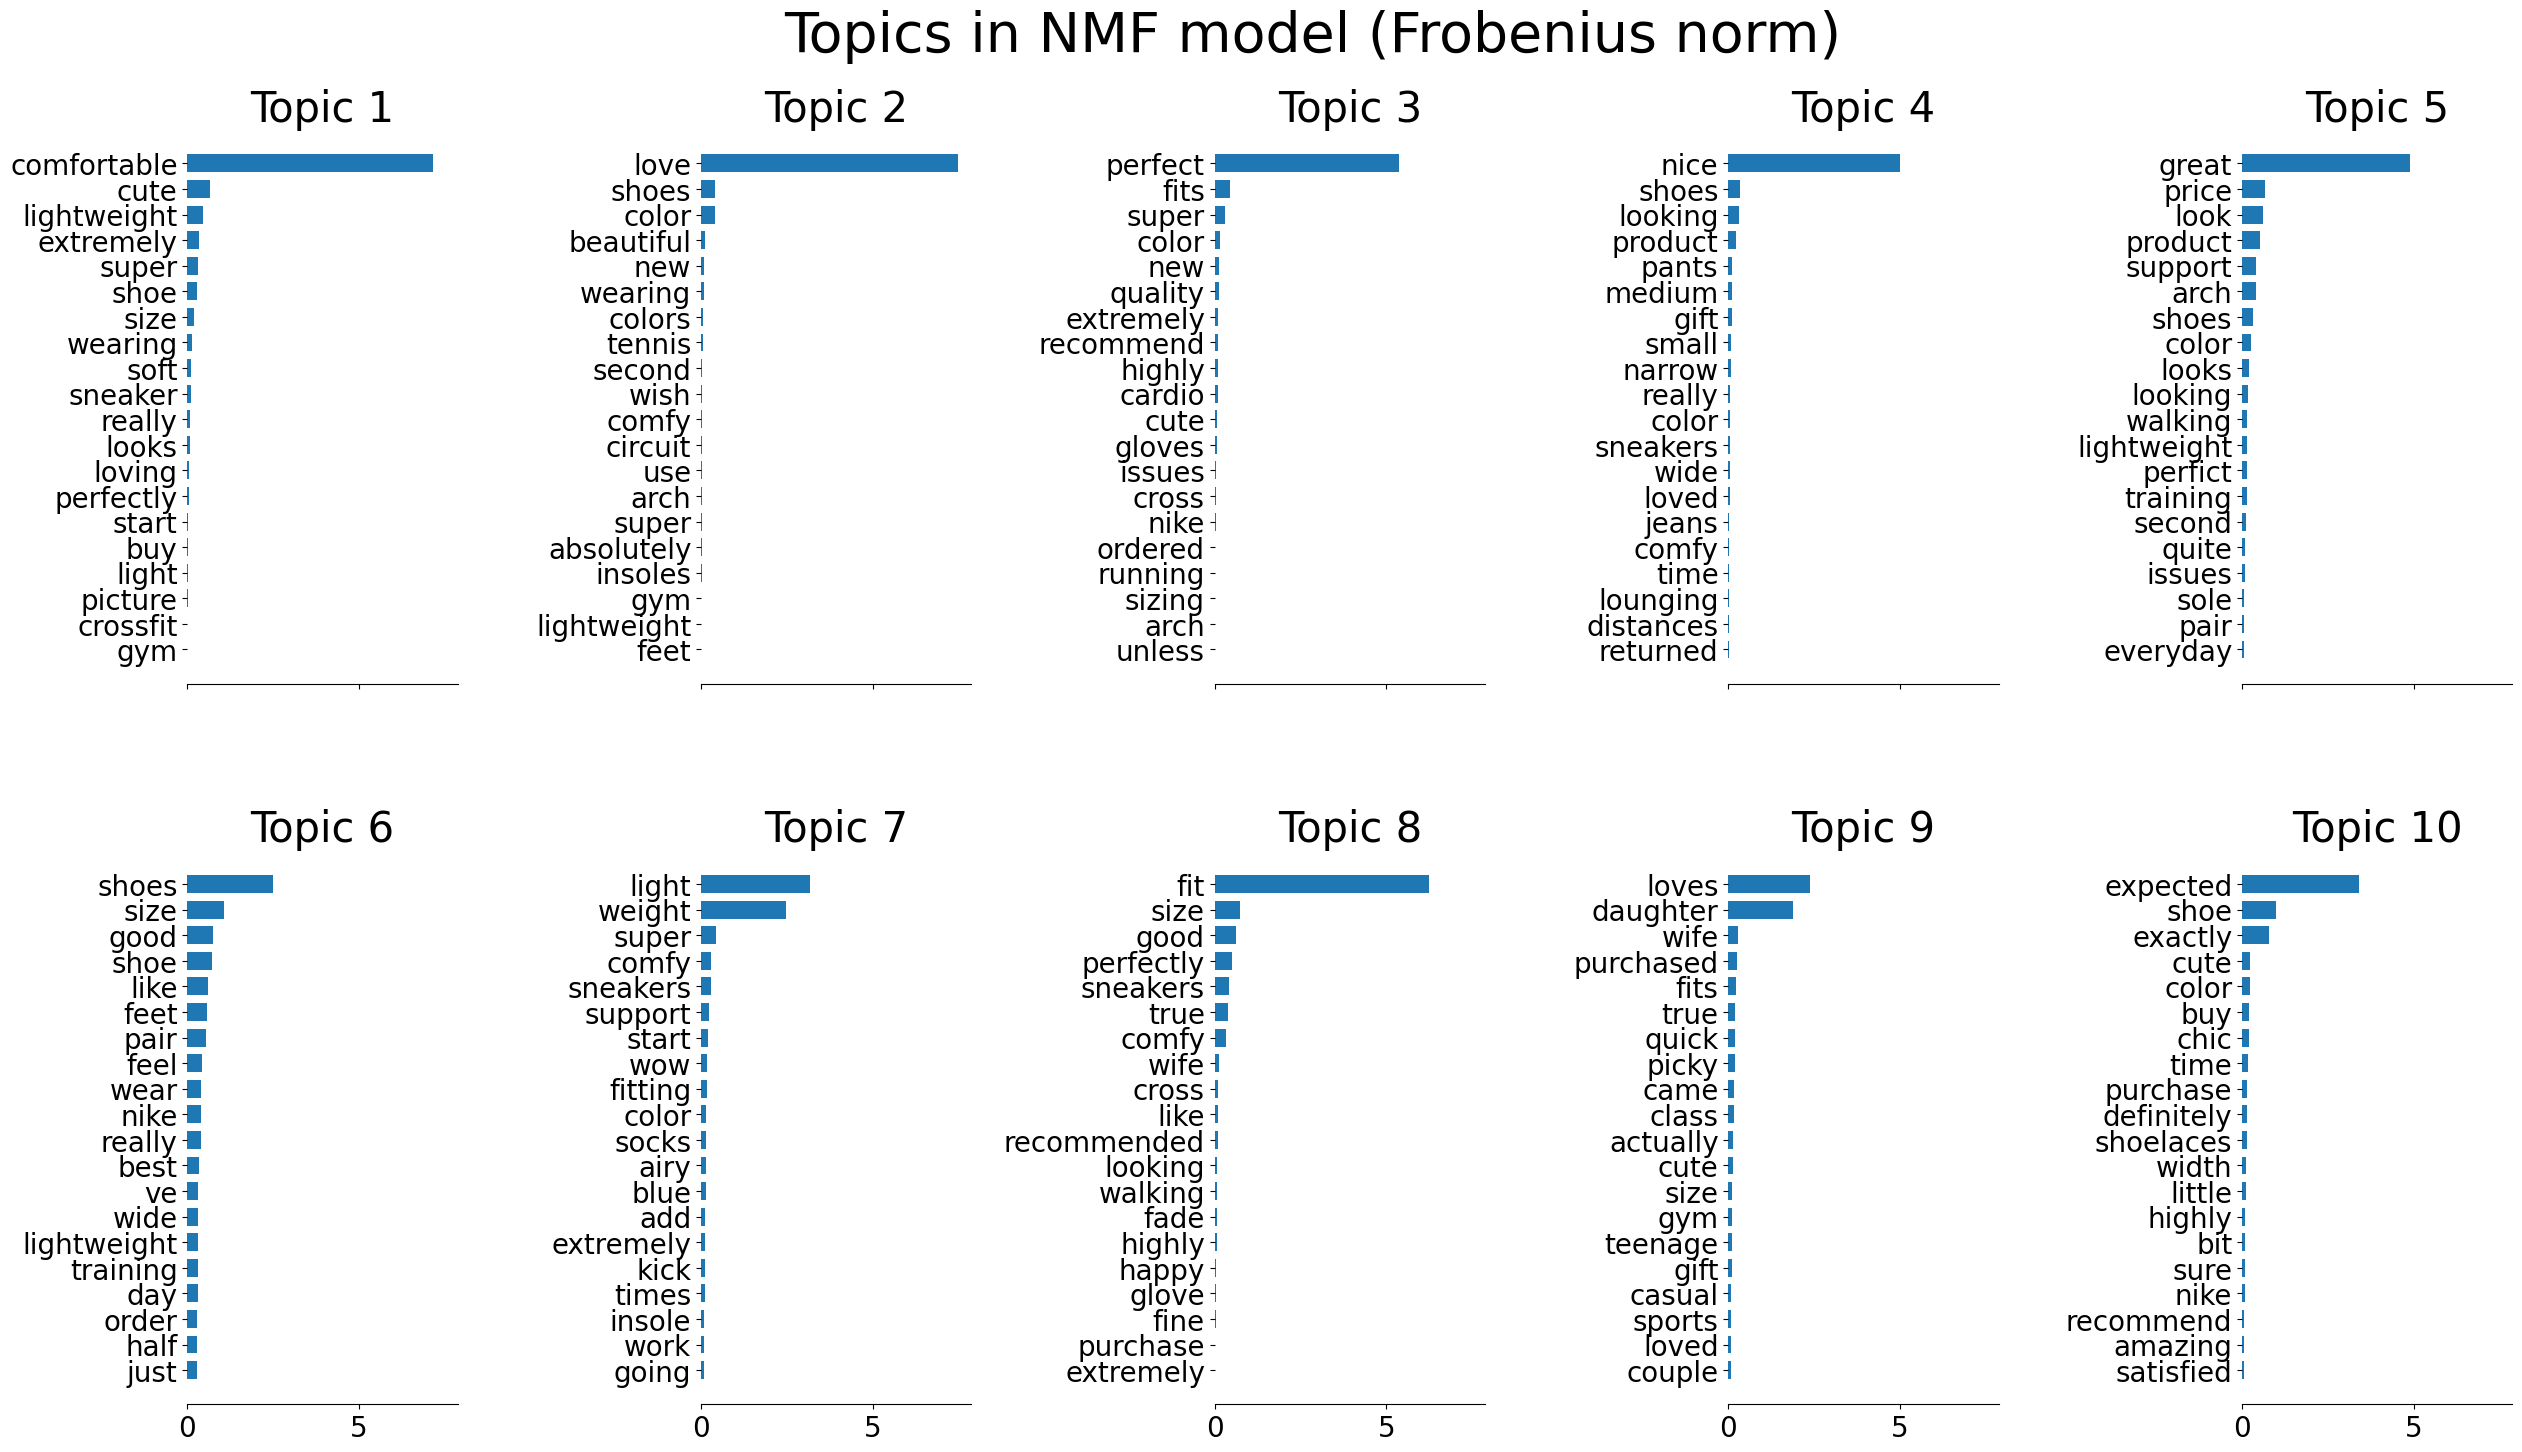

In [33]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf, 
    tfidf_feature_names, 
    n_top_words, 
    "Topics in NMF model (Frobenius norm)"
)

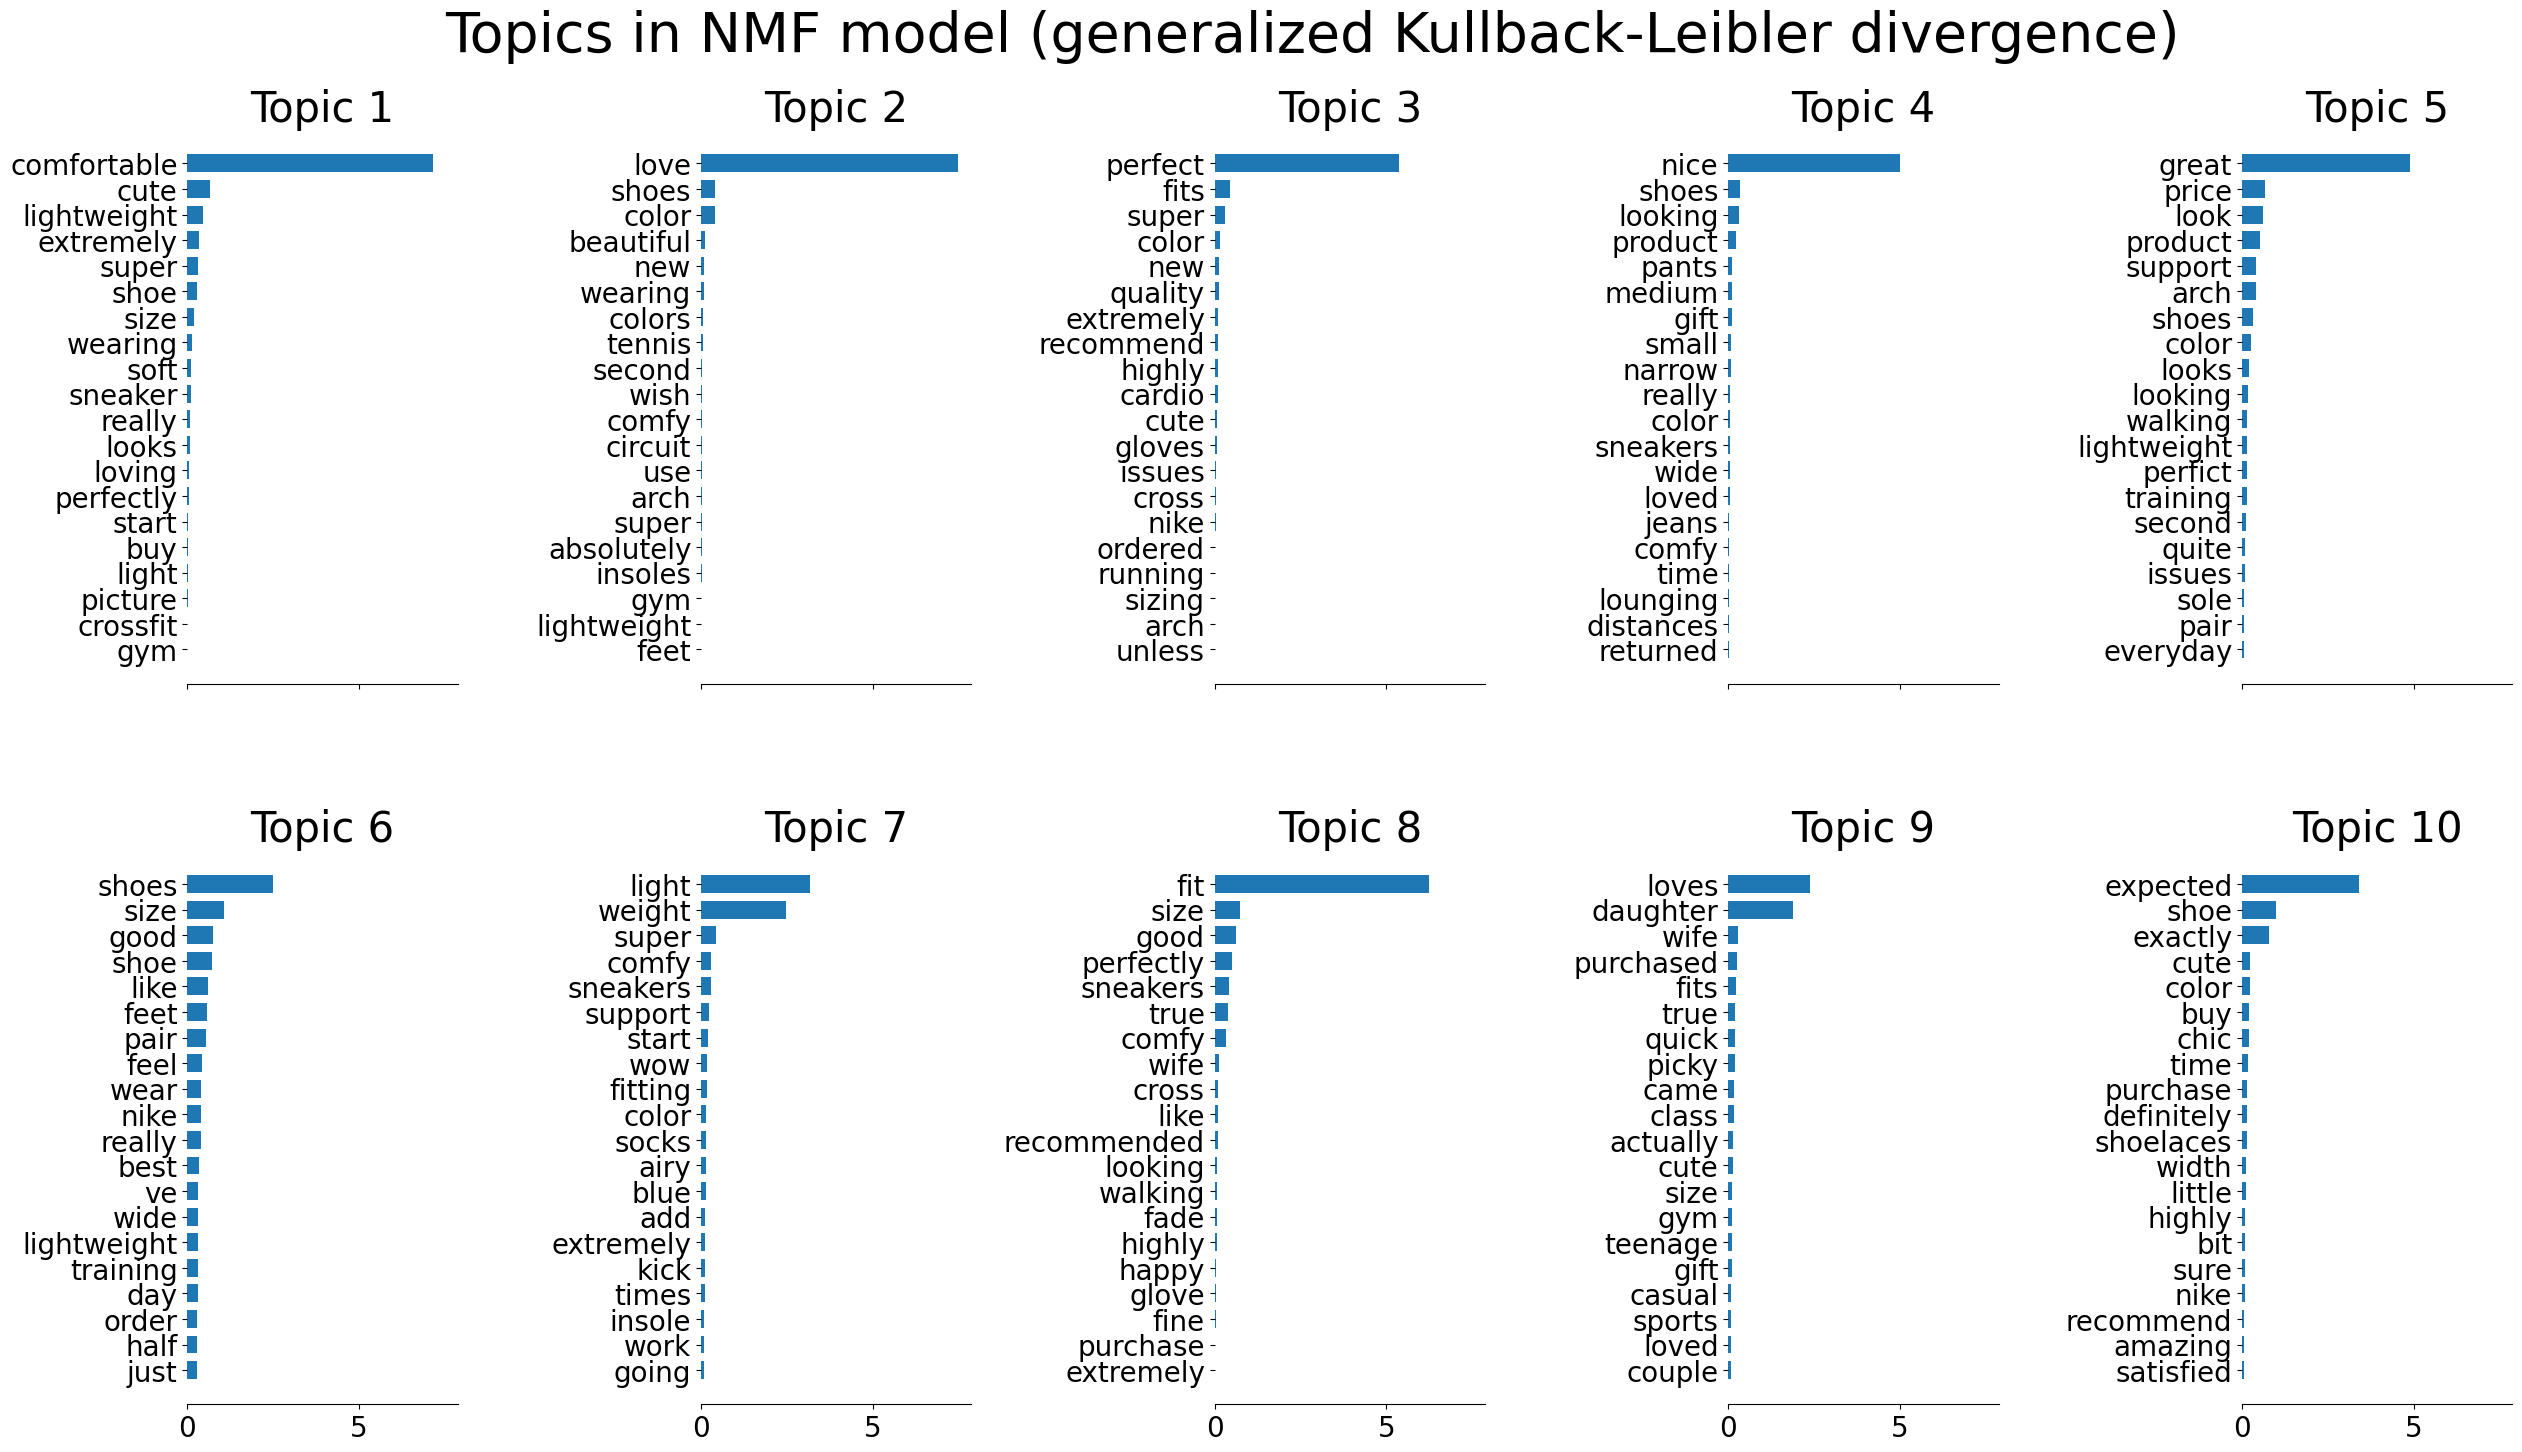

In [34]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

In [35]:
# Fit the MiniBatchNMF model
print(
    "\n" * 2,
    "Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf "
    "features, n_samples=%d and n_features=%d, batch_size=%d..."
    % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)



 Fitting the MiniBatchNMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


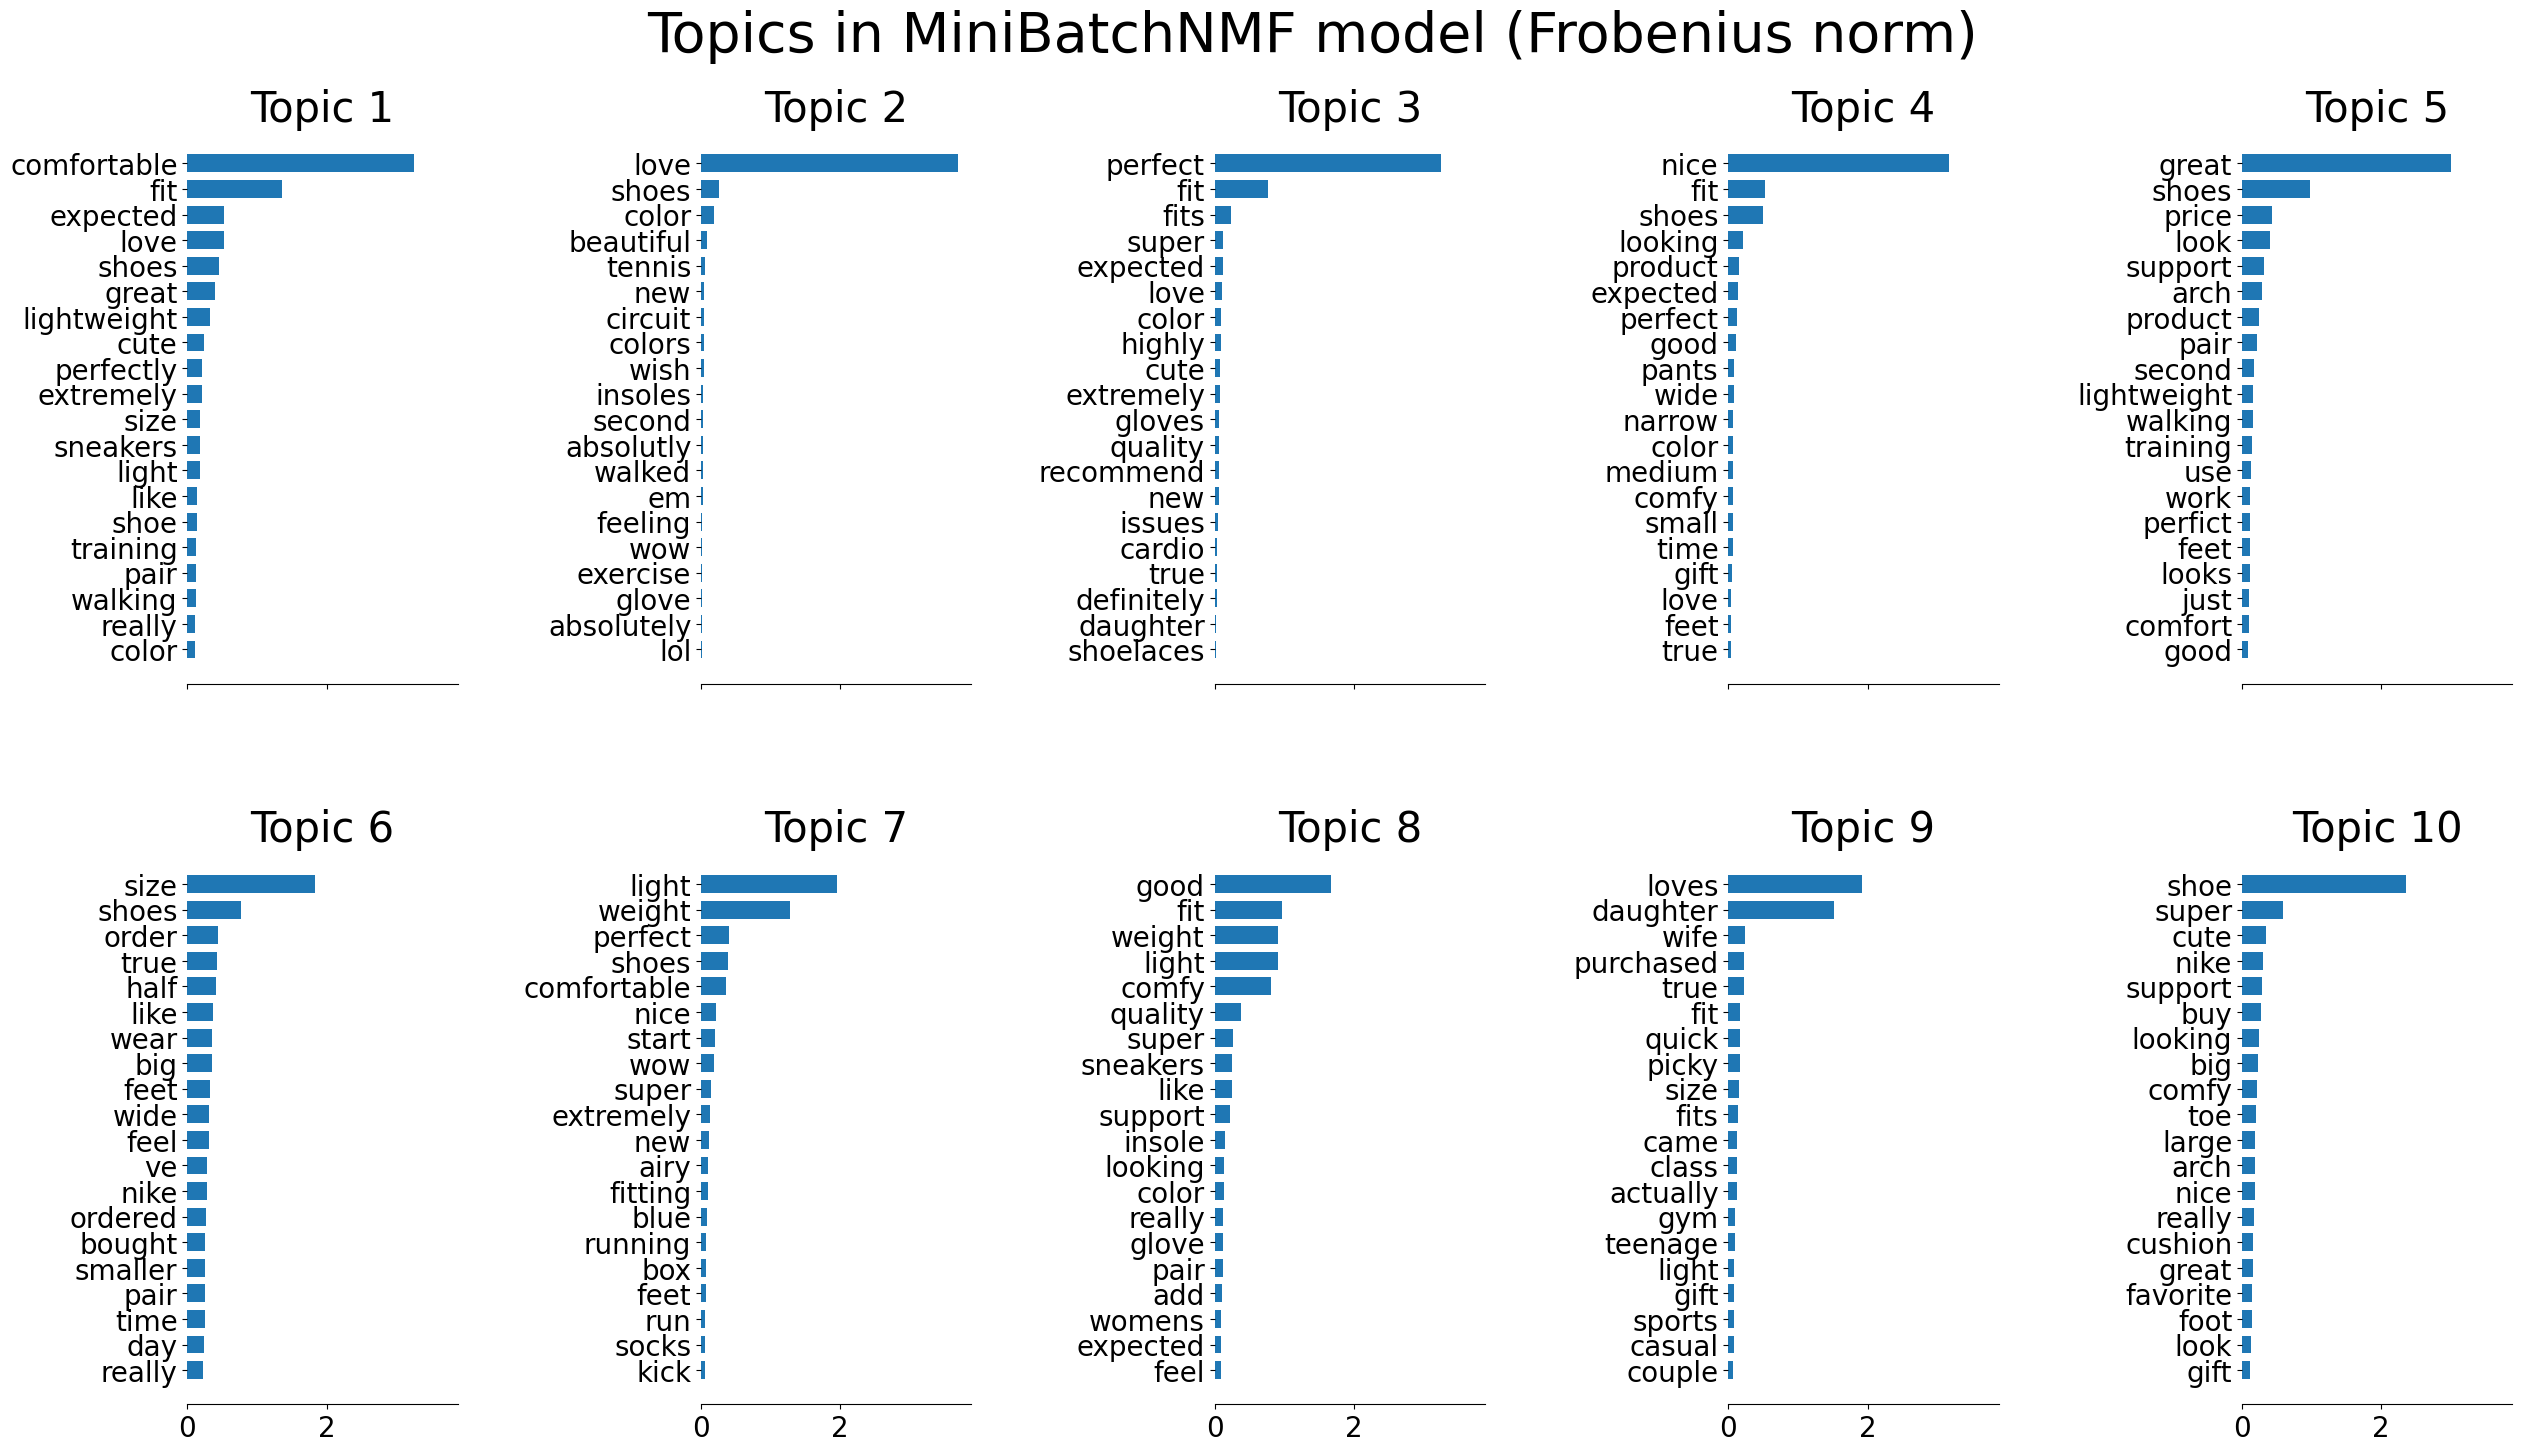

In [36]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (Frobenius norm)",
)

In [37]:
# Fit the MiniBatchNMF model
print(
    "Fitting the MiniBatchNMF model (generalized Kullback-Leibler "
    "divergence) with tf-idf features, n_samples=%d and n_features=%d, "
    "batch_size=%d..." % (n_samples, n_features, batch_size),
)
mbnmf = MiniBatchNMF(
    n_components=n_components,
    random_state=1,
    batch_size=batch_size,
    init=init,
    beta_loss="kullback-leibler",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)

Fitting the MiniBatchNMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000, batch_size=128...


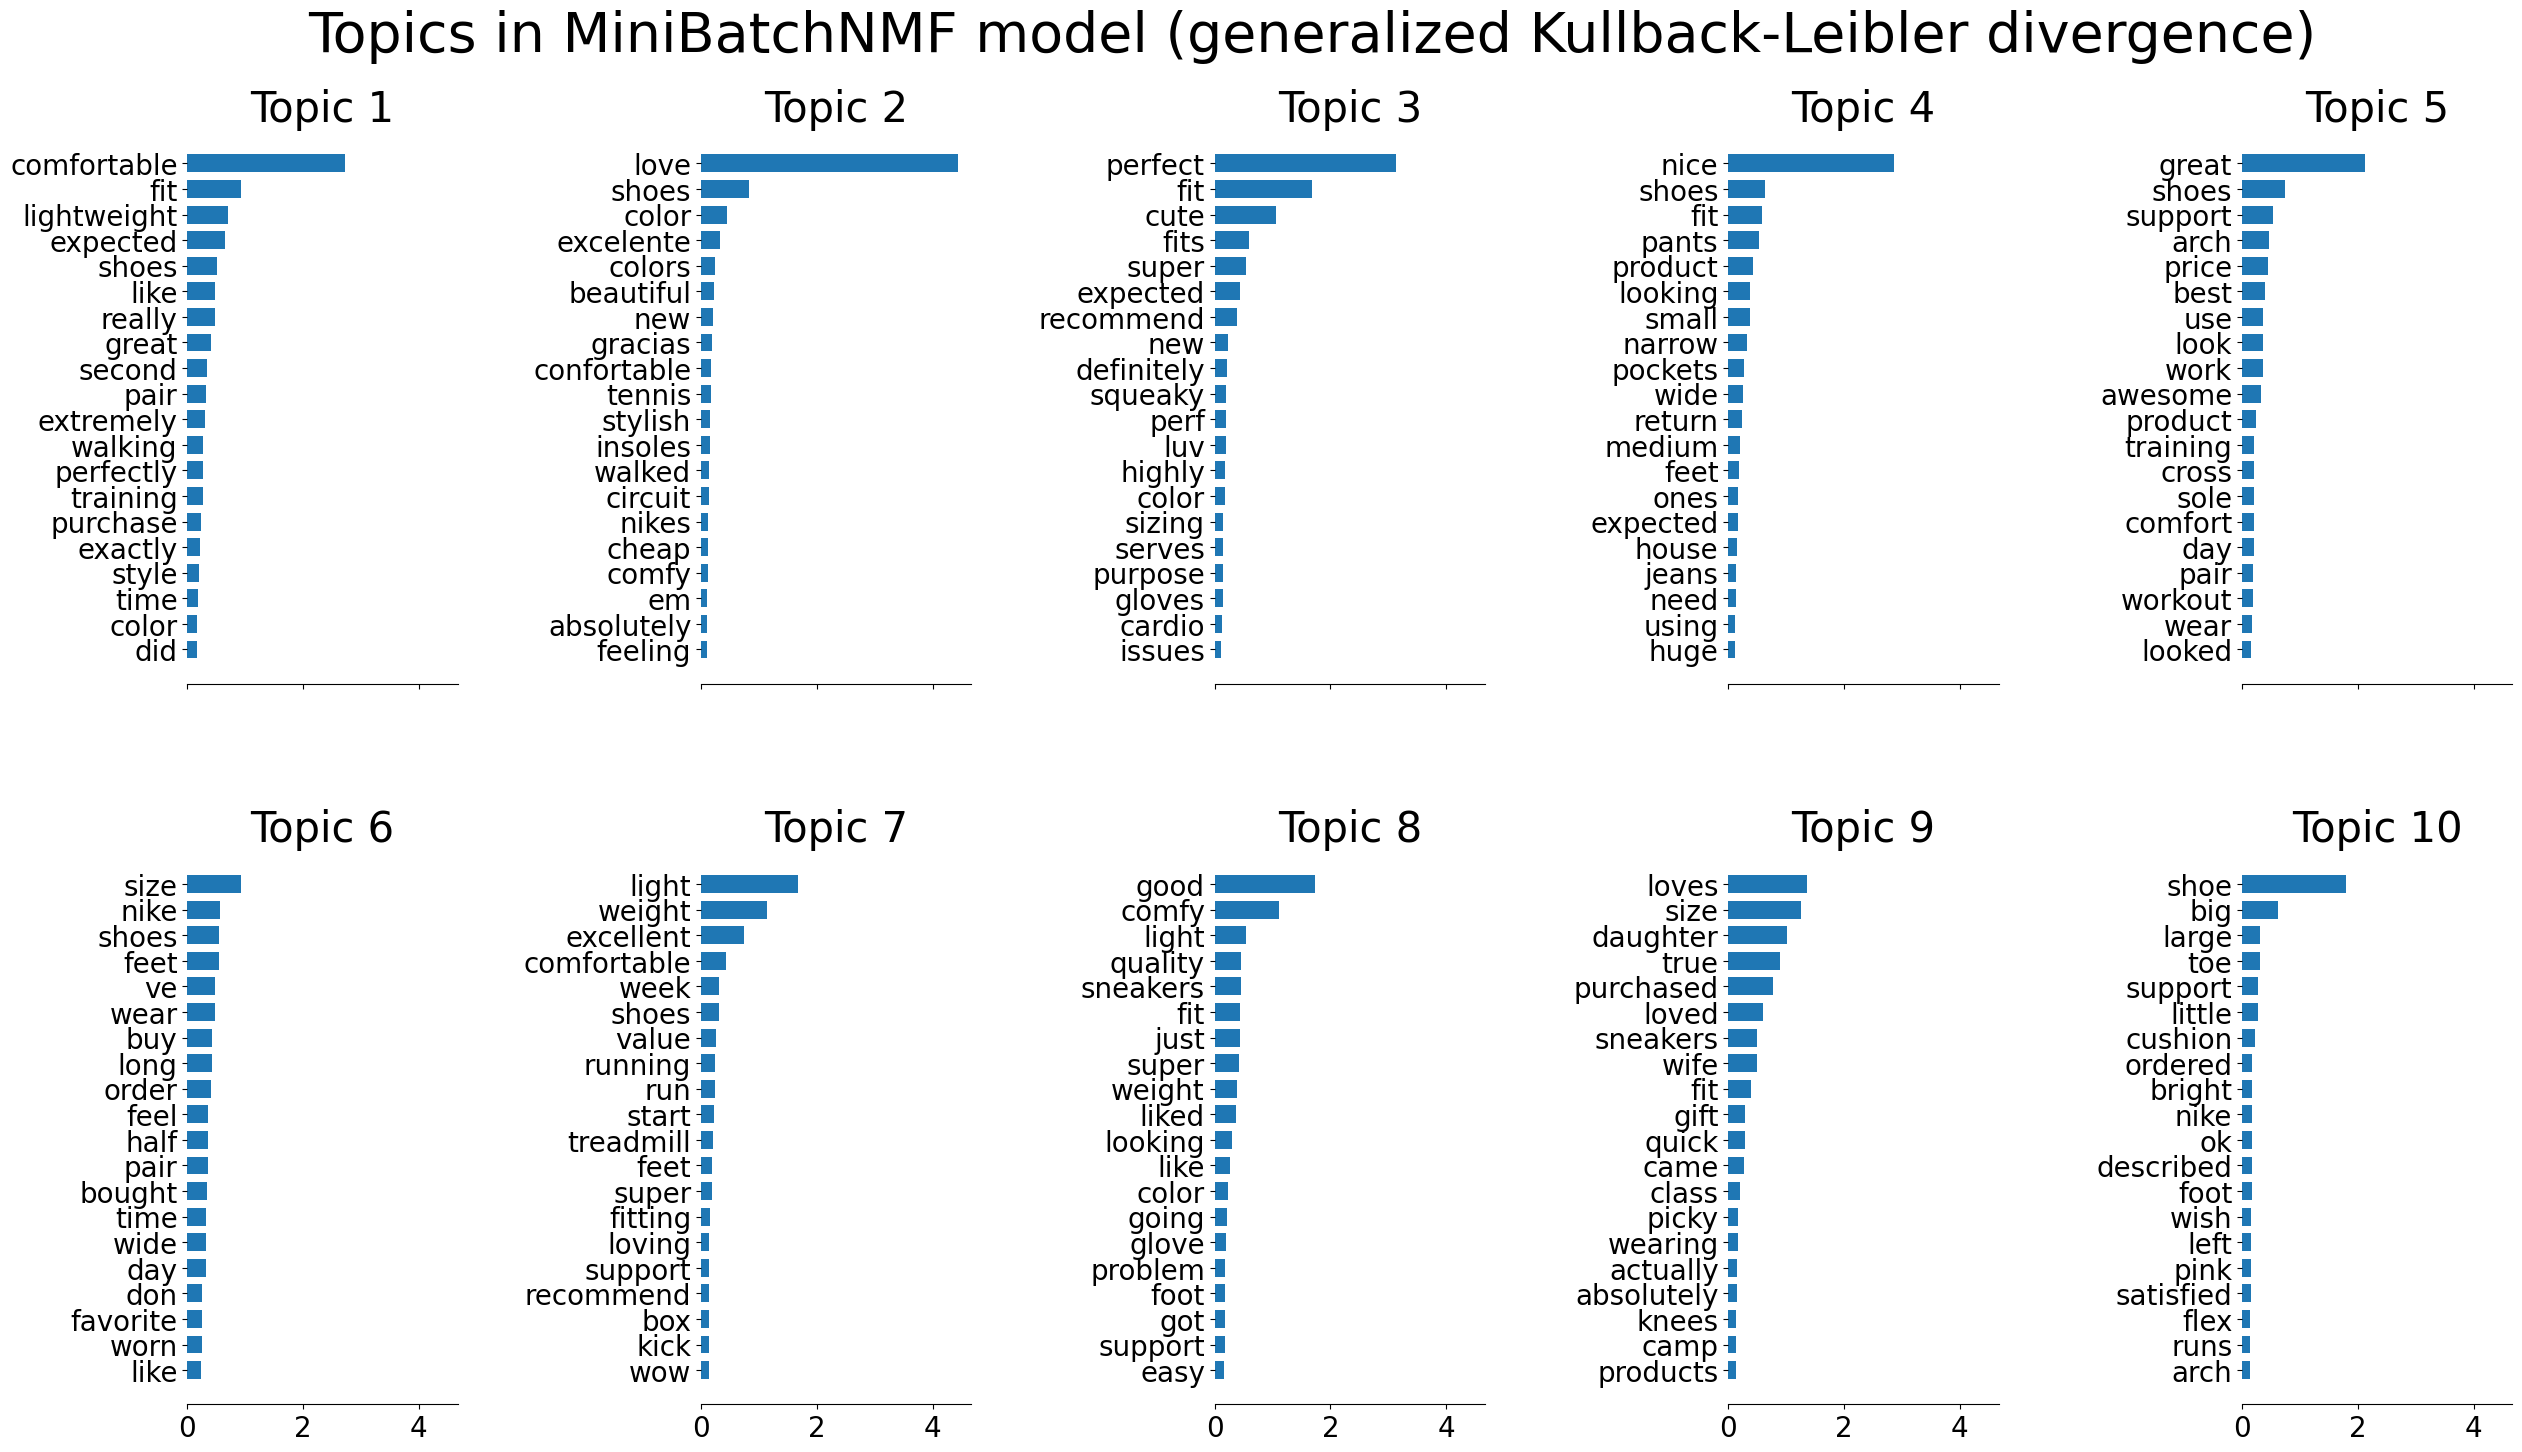

In [38]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    mbnmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in MiniBatchNMF model (generalized Kullback-Leibler divergence)",
)

In [46]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)

Extracting tf features for LDA...


Fitting LDA models with tf features, n_samples=2000 and n_features=1000...


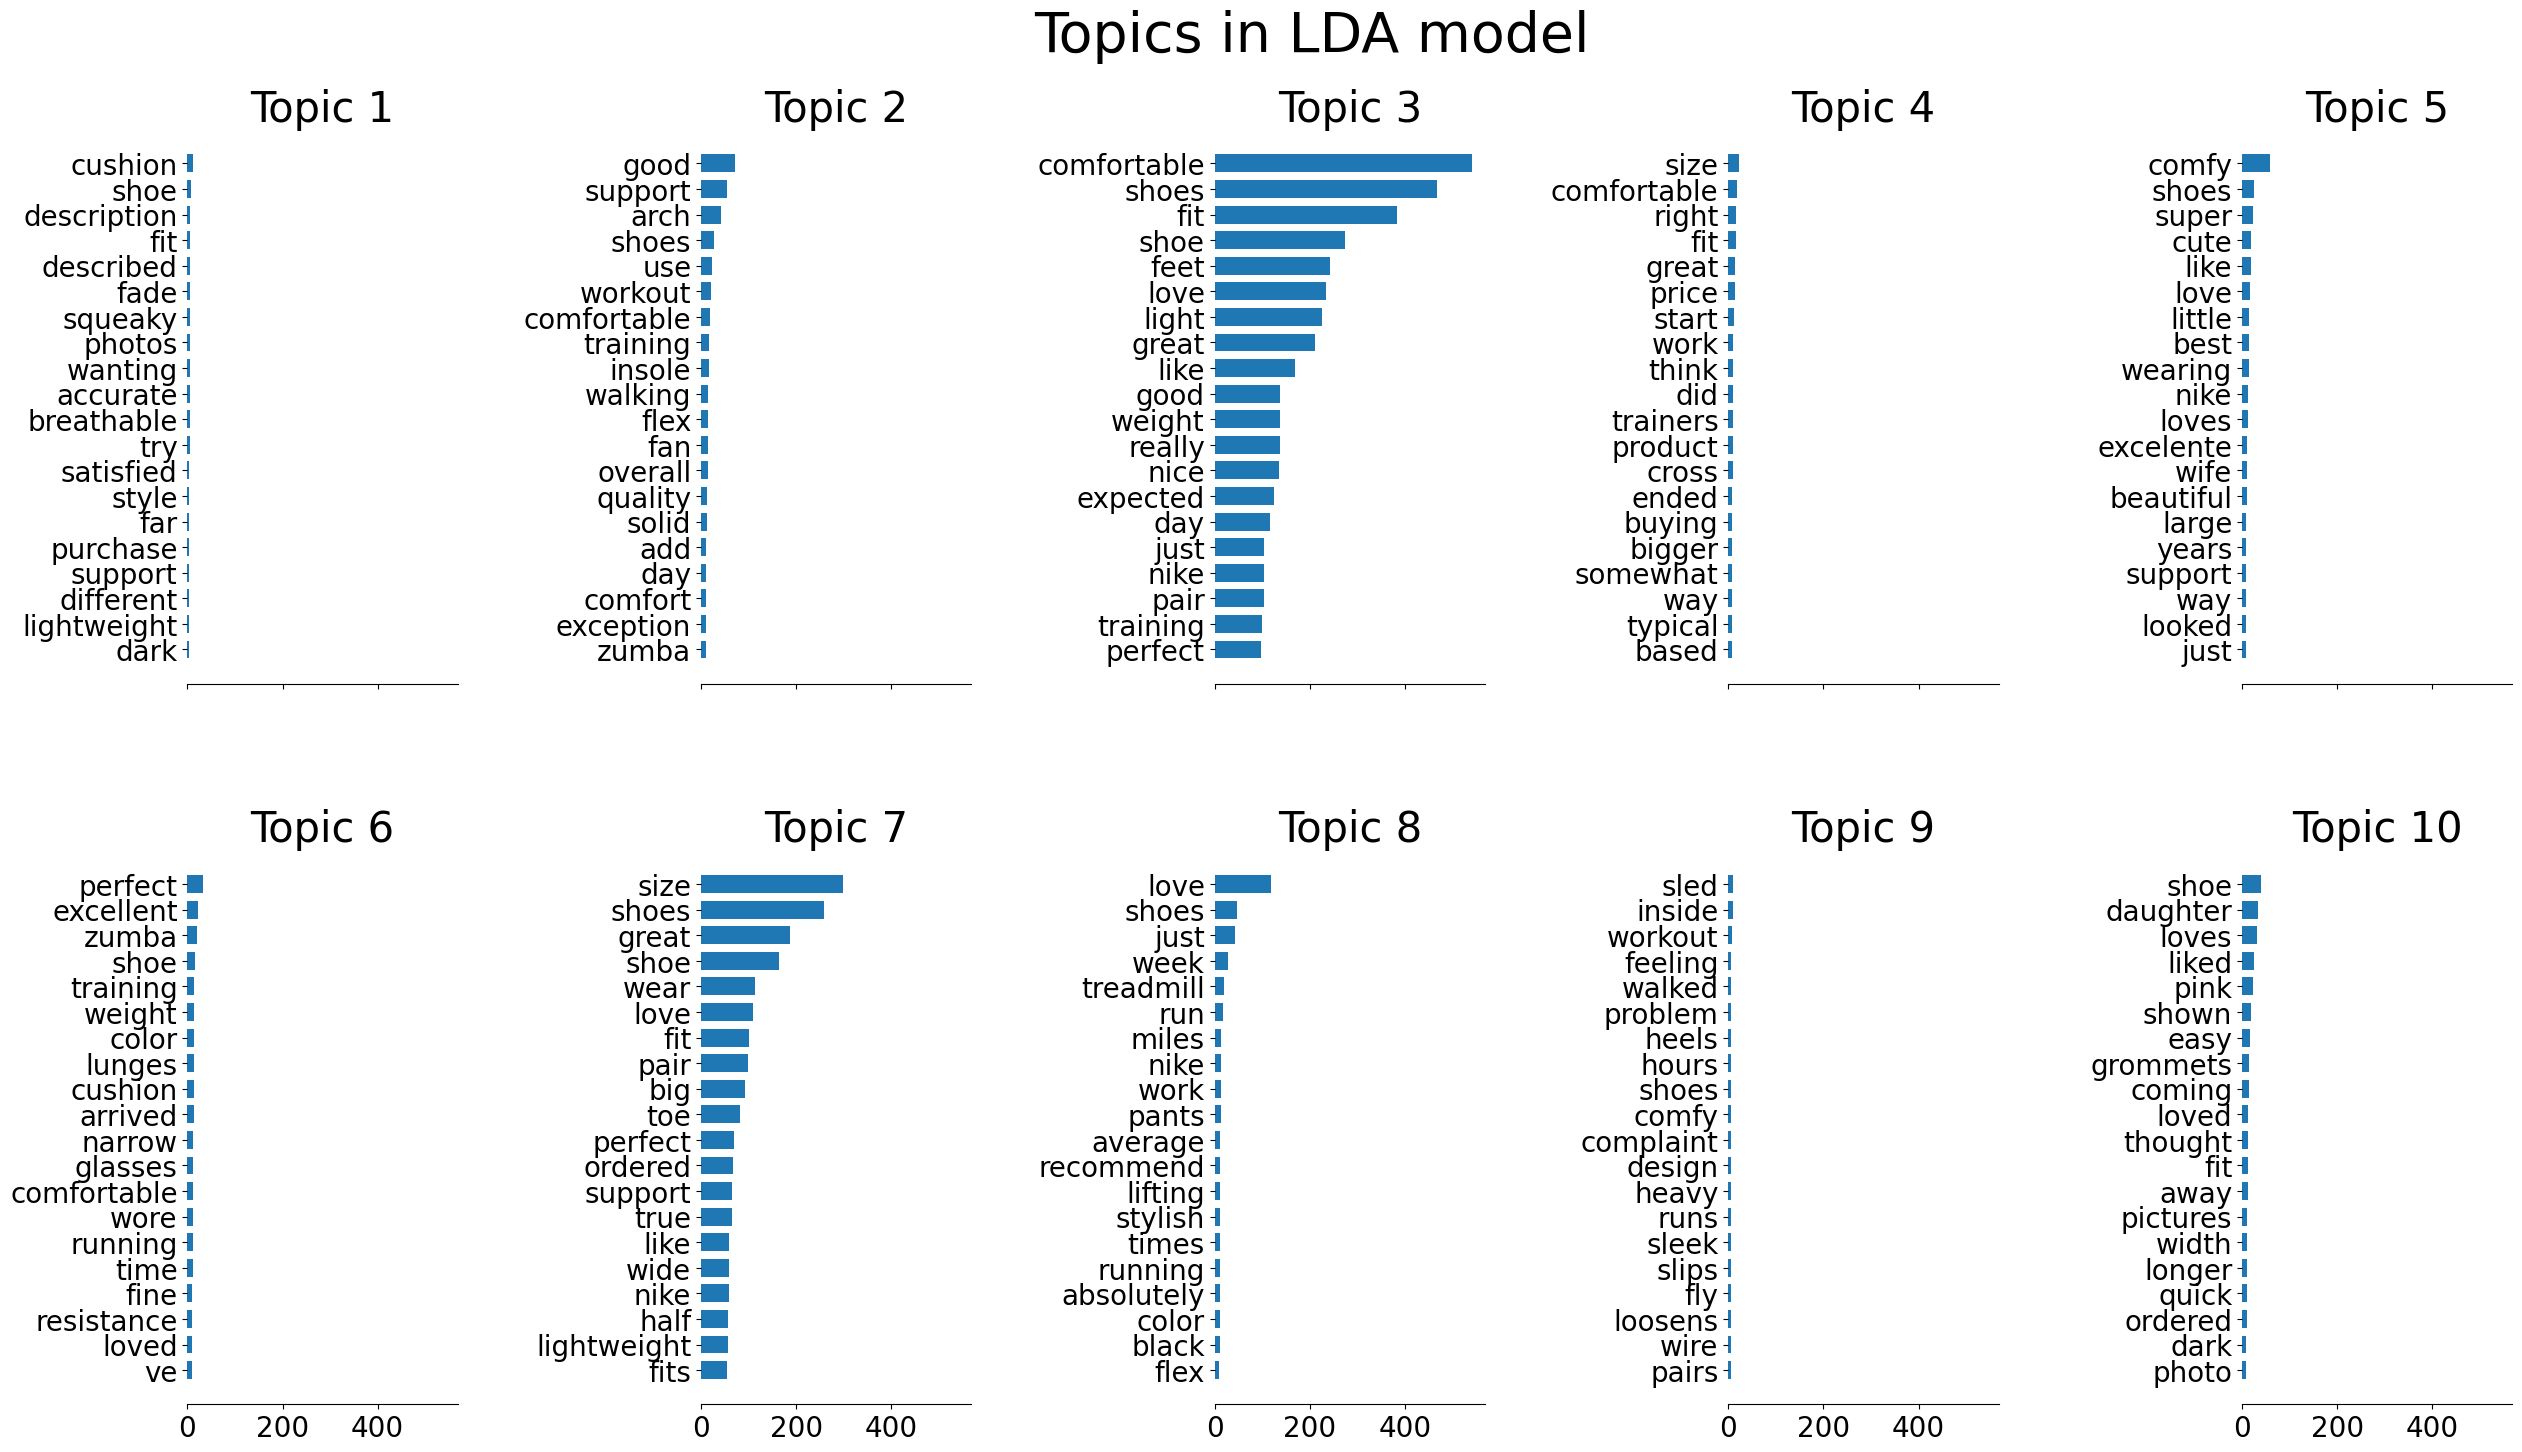

In [47]:
print(
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")